<a href="https://colab.research.google.com/github/Jack3690/pydol/blob/main/notebooks/JWST_Workshop_GH2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

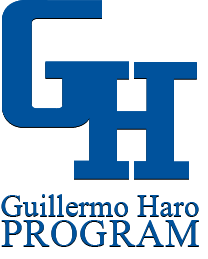

**James Webb Space Telescope NIRCAM Data Reduction Workshop**




# **Installs**

In [1]:
!pip install astroquery -q
!pip install jwst -q
!pip install crds -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.8/910.8 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# **Imports**

In [5]:
from glob import glob
import os
import astroquery
import astropy.io.fits as fits
from astroquery.mast import Observations
import astropy.io.fits as fits
from astropy.wcs import WCS
import multiprocessing as mp
import matplotlib.pyplot as plt

# **Data**

**Observation ID format**

jw\<ppppp>\<ooo><vvv>\_\<gg>\<s>\<aa>\_\<eeeee>(-<"seg"NNN>)\_\<detector>\_\<prodType>.fits

where

ppppp: program ID number

ooo: observation number

vvv: visit number

gg: visit group

s: parallel sequence ID (1=prime, 2-5=parallel)

aa: activity number (base 36)

eeeee: exposure number

segNNN: the text “seg” followed by a three-digit segment number (optional)

detector: detector name (e.g. ‘nrca1’, ‘nrcblong’, ‘mirimage’)

prodType: product type identifier (e.g. ‘uncal’, ‘rate’, ‘cal’)

In [ ]:
#Example data for F200W filter for NGC628

mast_dir = 'mast:jwst/product' # Download from MAST
data_dir = '/content/data/stage0/'  # save downloaded data
os.makedirs(data_dir, exist_ok=True)

ext = 'uncal'
# JWST images to be analyzed
image_files = []


for i in range(1,5):
    for j in range(1,5):
        for k in [7,8]:
            for l in ['a','b']:
                image_files.append( f"jw0178390400{k}_02101_0000{i}_nrc{l}{j}_{ext}.fits")
                break
            break
        break
    break

for image_file in image_files:
    # Download file (if not already downloaded)
    mast_path  = os.path.join(mast_dir, image_file)
    local_path = os.path.join(data_dir, image_file)
    Observations.download_file(mast_path, local_path=local_path)

In [ ]:
#Example data for M82

mast_dir = 'mast:jwst/product' # Download from MAST
data_dir = '/content/photometry/'  # save downloaded data
os.makedirs(data_dir, exist_ok=True)

# JWST images to be analyzed
image_files = [ f"jw01783-o904_t008_nircam_clear-f200w_i2d.fits"]

for image_file in image_files:
    # Download file (if not already downloaded)
    mast_path  = os.path.join(mast_dir, image_file)
    local_path = os.path.join(data_dir, image_file)
    Observations.download_file(mast_path, local_path=local_path)

In [ ]:
hdul = fits.open('/content/photometry/jw01701-o052_t007_nircam_clear-f212n-sub640_i2d.fits')

# **JWST Pipeline**

In [6]:
from jwst.pipeline import Detector1Pipeline, Image2Pipeline, Image3Pipeline

import numpy as np
from glob import glob
from crds import client
from astropy.table import Table

In [ ]:
os.environ['CRDS_PATH'] = '../CRDS/crds_cache/'
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"
os.environ["CRDS_CONTEXT"] = "jwst_1188.pmap"

os.makedirs(os.environ['CRDS_PATH'] , exist_ok=True)

## **Stage 1**

In [8]:
def stage1(filename, out_dir='/content/'):
    """
        Parameters
        ----------
        filename: str,
                  path to the level 0 "_uncal.fits" file
        out_dir: str,
                 path to the output directory
        Returns
        -------
            None
    """
    # Instantiate the pipeline
    img1 = Detector1Pipeline()
    # Snowball Removal (M82 Group)
    img1.jump.expand_large_events = True
    # Specify where the output should go
    img1.output_dir = out_dir + '/data/stage1/'
    # Save the final resulting _rate.fits files
    img1.save_results = True
    #No of cores
    img1.jump.maximum_cores = '11'
    # Run the pipeline on an input list of files
    img1(filename)

In [ ]:
uncal_flies = glob(f'/content/data/stage0/*a1*uncal.fits')

for f in uncal_flies:
  stage1(f)

## **Stage 2**

In [ ]:
def stage2(filename, out_dir='/content'):
        """
            Parameters
            ----------
            filename: str,
                      path to the level 1 "_rate.fits" file
            Returns
            -------
                None
        """
        # Instantiate the pipeline
        img2 = Image2Pipeline()
        # Specify where the output should go
        img2.output_dir = out_dir + '/data/stage2/'
        # Save the final resulting _rate.fits files
        img2.save_results = True
        # Run the pipeline on an input list of files
        img2(filename)

In [ ]:
rate_files = glob(f'/content/data/stage2/*a1*rate.fits')

for f in rate_files:
  stage2(f)

## **Stage 3**

In [ ]:
def stage3(filenames, out_dir='/content/'):
      """
          Parameters
          ----------
          filename: list,
                    paths to the level 2 "_cal.fits" file
          Returns
          -------
              None
      """
      # Instantiate the pipeline
      img3 = Image3Pipeline()
      # Specify where the output should go
      img3.output_dir = out_dir + '/data/stage3/'
      # Save the final resulting _rate.fits files
      img3.save_results = True
      # Run the pipeline on an input list of files
      img3(filenames)

In [ ]:
cal_files = glob(f'/content/data/stage3/*a1*cal.fits')

stage3(cal_files)

# **DOLPHOT Photometry**

INSTALL DOLPHOT

In [9]:
if 'dolphot2.0' not in os.environ['PATH']:
  os.environ['PATH'] += ':/content/dolphot2.0/bin'
  os.environ['PATH'] += ':/content/dolphot2.0/nircam'

In [10]:
crf_files = glob(f'/content/data/stage3/*b1*crf.fits')
drz_file = '/content/photometry/jw01783-o904_t008_nircam_clear-f200w_i2d'

## **NIRCAMMASK**

In [ ]:
!nircammask jw01783-o904_t008_nircam_clear-f200w_i2d.fits

In [ ]:
hdul = fits.open('/content/data/stage3/jw01783-o904_t008_nircam_clear-f200w_i2d_cal.fits')

In [ ]:
hdul[0].header

Make copy of all crf files and run nircammask on each of them

## **CALCSKY**

Repeat the code below for each crf file

In [ ]:
!calcsky /content/photometry/jw01783904007_02101_00001_nrca1_crf 10 25 2 2.25 2.00

## **Prepare the parameter file and run DOLPHOT**

In [ ]:
!dolphot -p/content/params/nircam_dolphot.param

# **Convert DOLPHOT Output to Astropy Table**

In [ ]:
!python /content/scripts/to_table.py --o F200W_photometry --n 4 --f /content/photometry/out/

In [ ]:
phot_table = Table.read(f"/content/F200W_photometry.fits")
phot_table.rename_columns(['mag_vega'],[f'mag_vega_{filter.upper()}'])

# Assingning RA-Dec using reference image
hdu = fits.open(f"{drz_file}.fits")[1]

wcs = WCS(hdu.header)
positions = np.transpose([phot_table['x'] - 0.5, phot_table['y']-0.5])

coords = np.array(wcs.pixel_to_world_values(positions))

phot_table['ra']  = coords[:,0]
phot_table['dec'] = coords[:,1]

# Filtering stellar photometry catalog using Warfield et.al (2023)
phot_table1 = phot_table[ (phot_table['sharpness']**2   <= 0.01) &
                            (phot_table['obj_crowd']    <=  0.5) &
                            (phot_table['flags']        <=    2) &
                            (phot_table['type']         <=    2)]

phot_table2 = phot_table[ ~((phot_table['sharpness']**2 <= 0.01) &
                            (phot_table['obj_crowd']    <=  0.5) &
                            (phot_table['flags']        <=    2) &
                            (phot_table['type']         <=    2))]

phot_table.write('/content/F200W_photometry.fits', overwrite=True)
phot_table1.write('/content/F200W_photometry_filt.fits', overwrite=True)
phot_table2.write('content/F200W_photometry_rej.fits', overwrite=True)